In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,confusion_matrix , precision_score , recall_score ,ConfusionMatrixDisplay , classification_report
from sklearn.model_selection import train_test_split , cross_val_score
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder ,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
df=pd.read_csv("/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")

In [4]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df = df[df['LoanAmount'] > 0]
df['LoanAmountLog'] = np.log1p(df['LoanAmount'])
df['DebtRatio'] = df['LoanAmount'] / (df['TotalIncome'] + 1)

In [5]:
df = df.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], axis=1)


In [6]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status'].map({'N': 0, 'Y': 1})

In [7]:
numeric_features = ['Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmountLog', 'DebtRatio']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [8]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42))
])

In [10]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)


In [11]:
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

🔹 Random Forest Accuracy: 0.8048780487804879
              precision    recall  f1-score   support

           0       0.91      0.49      0.64        43
           1       0.78      0.97      0.87        80

    accuracy                           0.80       123
   macro avg       0.85      0.73      0.75       123
weighted avg       0.83      0.80      0.79       123

Confusion Matrix:
 [[21 22]
 [ 2 78]]


In [12]:
rf_model = rf_pipeline.named_steps['classifier']
onehot_features = rf_pipeline.named_steps['preprocessing'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(onehot_features)

importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


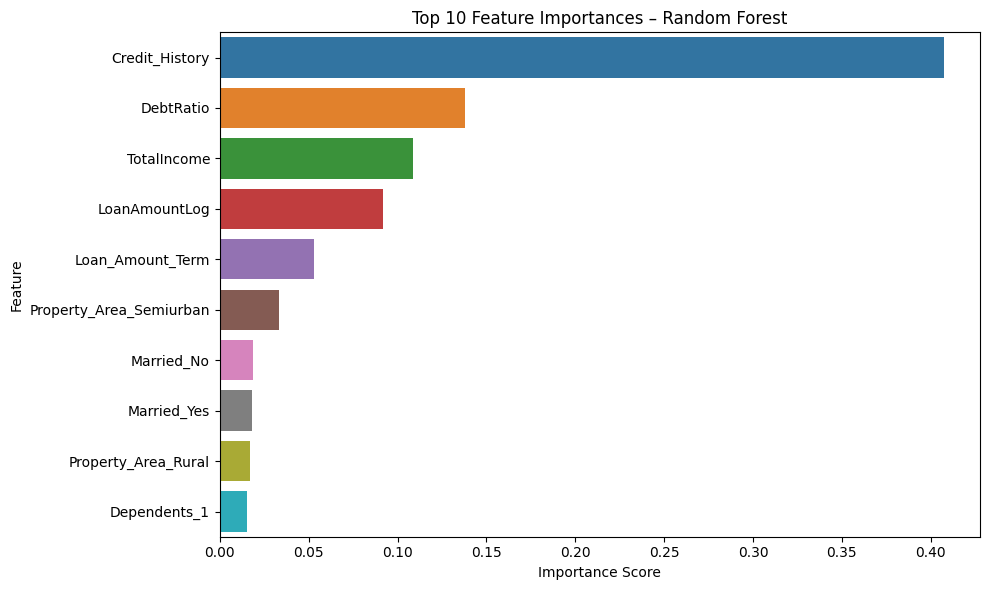

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title('Top 10 Feature Importances – Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()